# Вариант 2

## №1. A/B–тестирование
### Подготовка даннных

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import json
import numpy as np

In [2]:
# считывание .csv файлов с Яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
public_key_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'
public_key_group_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'

final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))  # формирование url
response_groups = requests.get(final_url_groups)  # запрос на извлечение данных по указанному url
download_url_groups = json.loads(response_groups.text)['href']  # парсинг данных
groups = pd.read_csv(download_url_groups, sep=';')  # считывание данных в формате dataframe

final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
response_active_studs = requests.get(final_url_active_studs)
download_url_active_studs = json.loads(response_active_studs.text)['href']
active_studs = pd.read_csv(download_url_active_studs, sep=';')

final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
response_checks = requests.get(final_url_checks)
download_url_checks = json.loads(response_checks.text)['href']
checks = pd.read_csv(download_url_checks, sep=';')

final_url_group_add = base_url + urlencode(dict(public_key=public_key_group_add))  # формирование url
response_group_add = requests.get(final_url_group_add)  # запрос на извлечение данных по указанному url
download_url_group_add = json.loads(response_group_add.text)['href']  # парсинг данных
group_add = pd.read_csv(download_url_group_add)  # считывание данных в формате dataframe

Смотрим данные

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
groups.query('grp == "A"').id.count()

14671

In [6]:
groups.query('grp == "B"').id.count()

59813

Размеры выборок сильно отличаются - тестовая больше

Объединим две таблицы с группами

In [7]:
all_groups = groups.append(group_add)

In [8]:
all_groups.duplicated(subset=['id']).sum()

0

Нет повторяющихся юзеров

Будем рассматривать юзеров, которые зашли на платформу в дни проведения эксперимента. То есть они видели изменения и участвовали в эксперименте.

In [9]:
active_users_by_groups = all_groups.merge(active_studs, how='inner', left_on='id', right_on='student_id').\
    drop(columns='student_id')

Добавим к таблице выручку с пользователей и получим финальную таблицу с данными по эксперименту

In [10]:
df = active_users_by_groups.\
    merge(checks, how='left', left_on='id', right_on='student_id').\
    drop(columns='student_id').\
    fillna(value={"rev": 0})

In [11]:
df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


Разделим таблицу на тестовую и контрольную группы

In [12]:
control = df.query('grp == "A"')
test = df.query('grp == "B"')

In [13]:
control.shape

(1538, 3)

In [14]:
test.shape

(6803, 3)

Тестовая группа по-прежнему больше контрольной

### Анализ

Рассмотрим следующие метрики:
1. Конверсия - отношение числа пользователей, совершивших покупку, к общему числу пользователей
2. ARPU - средний доход на пользователя
3. ARPPU - средний доход на платящего пользователя

### 1. Конверсия

In [86]:
n_ctrl = control.id.count()
CR_ctrl = control.query('rev > 0').id.count() / n_ctrl

In [90]:
CR_ctrl.round(3)

0.051

In [88]:
n_test = test.id.count()
CR_test = test.query('rev > 0').id.count() / n_test

In [91]:
CR_test.round(3)

0.046

Оценим стат значимость с помощью Z-теста для биноминального распределения.

Формула имеет следующий вид:

<img src="img-dE5Lvq.png" alt="Drawing" style="width: 200px;"/>

Дисперсия в группах

In [92]:
disp_ctrl = CR_ctrl * (1 - CR_ctrl)
disp_test = CR_test * (1 - CR_test)

Z-значение

In [93]:
Z = (CR_ctrl - CR_test) / np.sqrt((disp_ctrl / n_ctrl) + (disp_test / n_test))

Вычисление p-value для двустороннего критерия

In [95]:
from scipy.stats import norm

In [97]:
p_1_tail = 1 - norm.cdf(Z)
p_2_tail = p_1_tail * 2

In [99]:
p_2_tail

0.45821202783288095

Следовательно, разница в конверсии не является стат значимой

###  2. ARPU

In [20]:
ARPU_ctrl = control.rev.sum() / control.id.count()

In [21]:
ARPU_ctrl.round(2)

47.35

In [22]:
ARPU_test = test.rev.sum() / test.id.count()

In [23]:
ARPU_test.round(2)

58.06

In [24]:
round(100 * (ARPU_ctrl - ARPU_test) / ARPU_ctrl, 2)

-22.62

Посмотрим на распределение выручки

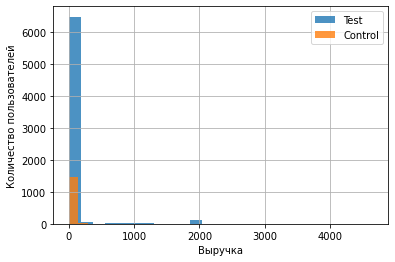

In [30]:
test.rev.hist(bins=25, alpha=0.8, label='Test')
control.rev.hist(bins=25, alpha=0.8, label='Control')

plt.xlabel('Выручка')
plt.ylabel('Количество пользователей')
plt.legend();

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


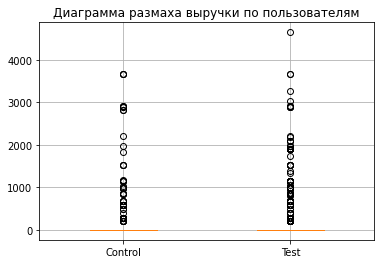

In [39]:
plt.boxplot([control.rev, test.rev],
            labels=['Control', 'Test'],
            widths=0.4)
plt.title('Диаграмма размаха выручки по пользователям', loc='center')
plt.grid(axis='both');

Проверим распределение на нормальность

In [40]:
from scipy.stats import shapiro

In [41]:
alpha = 0.05

st = shapiro(df.rev)
print('Distribution is {}normal\n'.format({True: 'not ', False: ''}[st[1] < alpha]));

Distribution is not normal



/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Оценим стат значимость. Так как распределение не является нормальным, применим непараметрический U-критерий Манна-Уитни.

Проверим нулевую гипотезу H0: средняя выручка (ARPU) по группам одинакова

In [42]:
from scipy.stats import mannwhitneyu

In [111]:
alpha = 0.05
st = mannwhitneyu(x=control.rev, y=test.rev)
 
print('Diffs is {}significant\n'.format({True: 'not ', False: ''}[st[1] > alpha]))

Diffs is not significant



### 3. ARPPU

In [25]:
ARPPU_ctrl = control.rev.sum() / control.query('rev > 0').id.count()

In [26]:
ARPPU_ctrl.round(2)

933.59

In [27]:
ARPPU_test = test.rev.sum() / test.query('rev > 0').id.count()

In [28]:
ARPPU_test.round(2)

1257.88

In [29]:
round(100 * (ARPPU_ctrl - ARPPU_test) / ARPPU_ctrl, 2)

-34.74

Посмотрим на распределение выручки у платящих пользователей

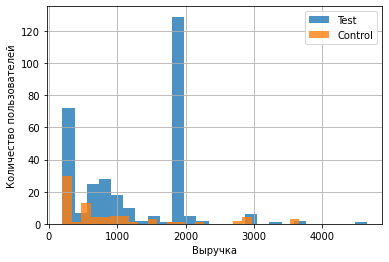

In [45]:
test.query('rev > 0').rev.hist(bins=25, alpha=0.8, label='Test')
control.query('rev > 0').rev.hist(bins=25, alpha=0.8, label='Control')

plt.xlabel('Выручка')
plt.ylabel('Количество пользователей')
plt.legend();

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


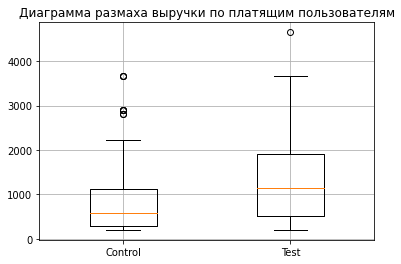

In [104]:
plt.boxplot([control.query('rev > 0').rev, test.query('rev > 0').rev],
            labels=['Control', 'Test'],
            widths=0.4)
plt.title('Диаграмма размаха выручки по платящим пользователям', loc='center')
plt.grid(axis='both');

Проверим распределение на нормальность

In [105]:
from scipy.stats import shapiro

In [109]:
alpha = 0.05

st = shapiro(df.query('rev > 0').rev)
print('Distribution is {}normal\n'.format({True: 'not ', False: ''}[st[1] < alpha]));

Distribution is not normal



Снова применим непараметрический U-критерий Манна-Уитни.

Нулевая гипотеза H0: средняя выручка от платящих пользователей по группам одинакова

In [107]:
from scipy.stats import mannwhitneyu

In [110]:
alpha = 0.05
st = mannwhitneyu(x=control.query('rev > 0').rev, y=test.query('rev > 0').rev)
 
print('Diffs is {}significant\n'.format({True: 'not ', False: ''}[st[1] > alpha]))

Diffs is significant



### Выводы:
1. Размер выборки контрольной группы меньше тестовой в 4 раза 
2. Конверсия статистически значимо не изменилась
3. Метрика ARPU статистически значимо не изменилась 
4. ARPPU в тестовой группе выше на 35%, отличие статистически значимо

### Рекомендации:

По имеющимся данным, можно сделать вывод, что нововведение имеет положительный эффект на ARPPU. То есть выручка от платящих пользователей увеличилась. Предлагаю запустить новую механику оплаты на всех пользователей.

Если это возможно, для более точного анализа можно провести эксперимент повторно при одинаковых размерах выборок.